In [1]:
%matplotlib inline

In [2]:
from IPython.display import HTML, Latex, Image

In [11]:
import matplotlib as mpl
mplpars = {'mathtext.fontset':'stix', 'font.family': 'STIXGeneral', 'font.size': 20,
           'lines.linewidth': 2, 'figure.dpi': 100, 'figure.figsize': (10,7),
           'legend.fontsize': 20.0, 'legend.frameon': False,}
mpl.rcParams.update(mplpars)

In [4]:
from scipy.signal import savgol_filter

In [5]:
# read time series from simulation
tser = pc.read_ts(quiet=True)
#
# get array index of z = 3000
t3k = search_indx(tser.zredshift, 3000, eps=5)
#
# b[z=300]
b0 = tser.brms[t3k]
#print(t3k, b0)

# In this Notebook we want to demonstrate our scalings of the Simulations

For this we need to scale the values of the magnetic field with the value of $B$ we got from equating alfven speed to sound speed in strong coupling regime. To compare our values of the heating rates we need to multiply with the square of our field strength in the simulation and the $1 nG$ which was used to get fig. 2 in the paper draft

In [6]:
# set physical values
B_phys = 1.32e-6
vA_phys = B_phys/np.sqrt(4*np.pi) # in Gauss
cs_phys = 5.76e5
#
# Cosmological Scaling variables
rho_crit = 8.62e-30
omega_b = 0.0486
rho_gamma = 4.17e-13
rho_b = rho_crit*omega_b
#
# calculate factor to compare to 1nG (Jens' fig. 2)
B_fac = tser.brms[t3k]*B_phys
nG = 1.0e-9
#
# scale the magnetic field
brms_phys = tser.brms*vA_phys
urms_phys = tser.urms*vA_phys #cs_phys
#
# Scale the drag force
alpha_phys = tser.alpha_drag*vA_phys
#
# Calculate the energies
Em = 0.5*brms_phys**2 #
Ek = 0.5*urms_phys**2 #
#

## We now calculate the Rates using finite differences

Since we want the $\log$ derivative we multiply by $z$ after doing $dE/dz$

All rates are rescaled by the photon density $\rho_\gamma$ at the current epoch and the square of how much our magnetic field is stronger than a nano Gauss

In [7]:
# redshift diff
#
z = tser.zredshift

dz = np.diff(tser.zredshift)
#dz = tser.zredshift[1:] - tser.zredshift[:-1]
#
scale = rho_gamma*(B_fac/nG)**2
#
dEm_dz = np.diff(Em)/dz
dEk_dz = np.diff(Ek)/dz
#
dEm_dlnz = np.diff(Em)/dz*z[:-1]/scale
dEk_dlnz = np.diff(Ek)/dz*z[:-1]/scale
#
#Eges = Em + Ek
#dEgesdz = np.diff(Eges)/dz
dEgesdlnz = dEm_dlnz + dEk_dlnz #np.diff(Eges)/dz*z[:-1]
#
# Calculating the drag term
drag_unscaled = 3/2*tser.alpha_drag*tser.urms**2
drag = 3/2*tser.alpha_drag*urms_phys**2/scale
#print(drag[t3k], drag_unscaled[t3k], scale)

# Calculate difference between dEgesdlnz and the drag
diffEdrag = abs(dEgesdlnz- drag[:-1])
#
# Smooth the curve
smooth3 = savgol_filter(diffEdrag,51, 3)
#print(smooth3.shape, type(smooth3), np.where(z < 4000)[0][0])

## Now we do the plots. 

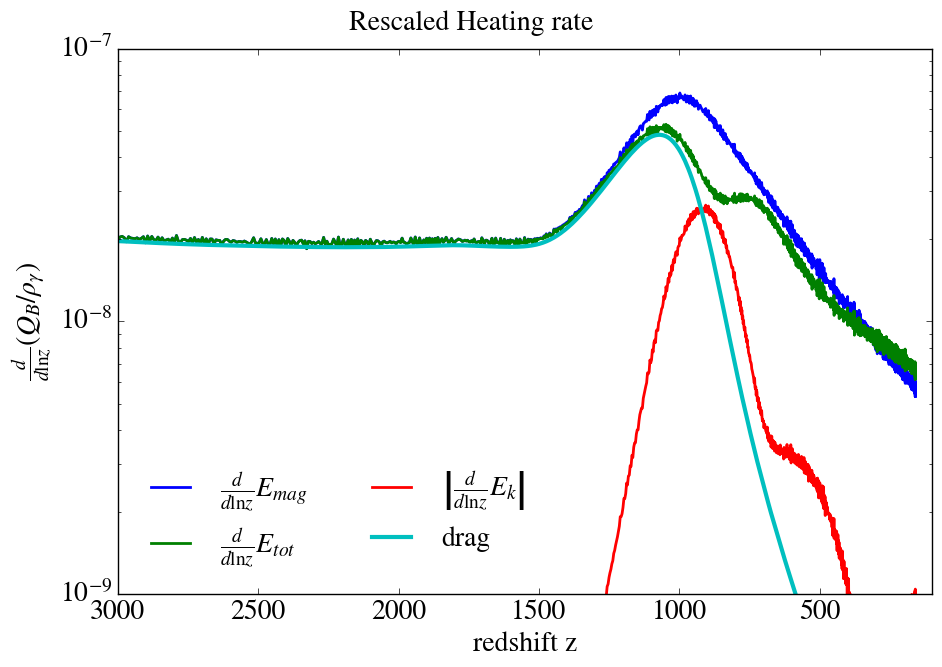

In [12]:
# create a figure
hfig2, hax2 = plt.subplots()
#
# plot the lines
l1 = hax2.plot(z[:-1], dEm_dlnz, label=r'$\frac{d}{d\ln z} E_{mag}$')
l2 = hax2.plot(z[:-1], dEgesdlnz, label=r'$\frac{d}{d\ln z}E_{tot}$')
l3 = hax2.plot(z[:-1], abs(dEk_dlnz), label=r'$\left|\frac{d}{d\ln z}E_{k}\right|$') 
l4 = hax2.plot(tser.zredshift, drag, label=r'drag', linewidth=3)# $=3/2 \cdot \alpha u^2$', linewidth=3)
#l5 = hax2.plot(z[:-1], smooth3)
lns = l1 + l2 + l3 + l4 #+ l6
lbls = [l.get_label() for l in lns]
hax2.set_xlim(3000,100)
hax2.set_ylim(1e-9, 1e-7)
hax2.set_xlabel('redshift z')
hax2.set_ylabel(r'$\frac{d}{d\ln z}(Q_B/\rho_\gamma)$')
hax2.set_yscale('log')
#hax2.set_xscale('log')
hax2.legend(lns, lbls, loc='lower left', ncol=2)
hfig2.suptitle(r'Rescaled Heating rate')
hfig2.tight_layout(pad=1.4)
#hax2.set_xscale('log')